In [16]:
import pybinding as pb
import numpy as np
from numpy import sqrt as sqrt
import matplotlib.pyplot as plt
from numpy import exp, dot, einsum, cos, sin, pi
import sympy as sp
from math import gcd

# Finite lattices of sizes 2x2, 7x7 and 10x10 via pybinding

In [5]:
def spectrum(N, alpha):
    a = 1 #lattice constant
    # onsite energies
    Ea = 0
    Eb = 0
    
    # lattice vectors
    a1 = np.array([a, 0])
    a2 = np.array([0, a])
    square_lattice = pb.Lattice(a1=a1, a2=a2)
    for i in range(0, N):
        for j in range(0, N):
            square_lattice.add_one_sublattice(f'A{i}-{j}', np.array([i*a, j*a]), Ea
                                             )  # add an atom called 'A' at position [0, 0]
    
    # nearest-neighbor hopping
    t = -1
    for i in range(0, N):
        for j in range(0, N):
            try:
                square_lattice.add_one_hopping([0, 0], f'A{i}-{j}', f'A{i+1}-{j}', t)
            except:
                pass
            try:
                square_lattice.add_one_hopping([0, 0], f'A{i}-{j}', f'A{i}-{j+1}', t*np.exp(2*np.pi*1j*i*alpha))
            except:
                pass
    square_model = pb.Model(square_lattice)
    solver = pb.solver.lapack(square_model)
    return solver.eigenvalues


In [6]:
alphas = np.linspace(0, 1, 100)
spectra_2_by_2 = np.zeros((100, 4))
spectra_7_by_7 = np.zeros((100, 49))
spectra_10_by_10 = np.zeros((100, 100))

In [7]:
for (i, alpha) in enumerate(alphas):
    spectra_2_by_2[i, :] = spectrum(2, alpha)
    spectra_7_by_7[i, :] = spectrum(7, alpha)
    spectra_10_by_10[i, :] = spectrum(10, alpha)

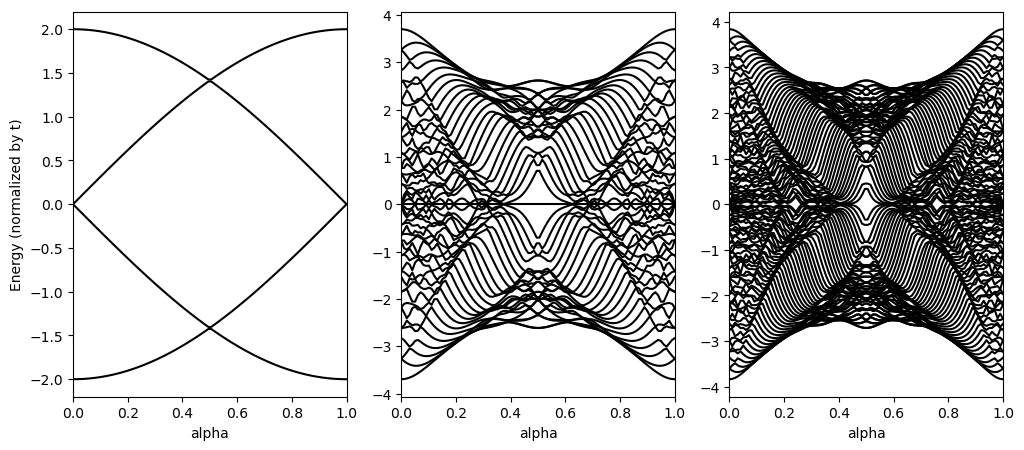

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].plot(alphas, spectra_2_by_2, color="black");
axs[1].plot(alphas, spectra_7_by_7, color="black");
axs[2].plot(alphas, spectra_10_by_10, color="black");

axs[0].set_xlim(0, 1);
axs[0].set_ylabel("Energy (normalized by t)")

axs[0].set_xlabel("alpha")
axs[1].set_xlabel("alpha")
axs[2].set_xlabel("alpha")

axs[1].set_xlim(0, 1);
axs[2].set_xlim(0, 1);

# Now we solve in the Landau gauge with an effective 1D Hamiltonian

In [41]:
t = -1
def one_dimensional_spectrum(N, alpha, k):
    H = np.zeros((N, N))
    for i in range(0, N):
        H[i, i] = 2*t*np.cos(2*pi*i*alpha + 2*pi*k/N)
    for i in range(0, N-1):
        H[i, i+1] = t
    for i in range(1, N):
        H[i, i-1] = t
    return np.linalg.eigvals(H)

In [51]:
N = 180
ks = np.linspace(0, N-1, N)
alphas = np.linspace(0, 1, N+1)

In [52]:
energies = np.zeros((N+1, N**2))
for (i, alpha) in enumerate(alphas):
    #print(i)
    energies_at_alpha = []
    for k in ks:
        energies_at_alpha.append(one_dimensional_spectrum(N, alpha, k))
    energies[i, :] = np.array(energies_at_alpha).flatten()

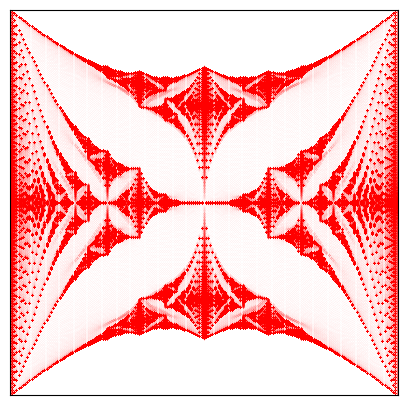

In [35]:
plt.figure(figsize=(5, 5))
for (i, alpha) in enumerate(alphas):
    plt.scatter(np.ones(N**2)*alpha, energies[i, :], s=0.0001, color="red")
plt.xlim(0, 1);
plt.ylim(-4, 4);
plt.xticks([])
plt.yticks([]);

# Now we put in periodic boundary conditions and only sample commensurate k values to simulate the truly infinite system

In [20]:
t = -1
def one_dimensional_spectrum_periodic(N, alpha, k):
    H = np.zeros((N, N))
    for i in range(0, N):
        H[i, i] = 2*t*np.cos(2*pi*i*alpha + 2*pi*k/N)
    for i in range(0, N-1):
        H[i, i+1] = t
    for i in range(1, N):
        H[i, i-1] = t
    H[0, N-1] = t
    H[N-1, 0] = t
    return np.linalg.eigvals(H)

In [29]:
N = 120
ks = np.linspace(0, N-1, N)
alphas = np.linspace(0, 1, N+1)

In [31]:
energies = np.zeros((N+1, N**2), dtype=complex)
for (i, alpha) in enumerate(alphas):
    if (i % 20) == 0: 
        print(i)
    energies_at_alpha = []
    for k in ks:
        energies_at_alpha.append(one_dimensional_spectrum_periodic(N, alpha, k))
    energies[i, :] = np.array(energies_at_alpha).flatten()

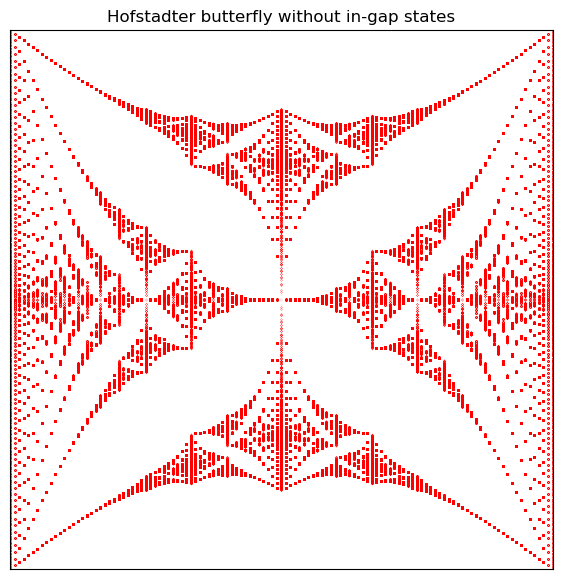

In [28]:
plt.figure(figsize=(7, 7))
for (i, alpha) in enumerate(alphas):
    plt.scatter(np.ones(N**2)*alpha, energies[i, :].real, s=0.001, color="red")
plt.xlim(0, 1);
plt.ylim(-4, 4);
plt.xticks([])
plt.yticks([]);
plt.title("Hofstadter butterfly without in-gap states");

# Now we do the same in pybinding: Choosing a commensurate unit cell with respect to the magnetic field

In [69]:
def periodic_spectrum(n, N, nk):
    alpha = n/N
    Nprime = int(N/gcd(n, N)) # smallest commensurate unit cell
    print(f"Choosing unit cell of size: {Nprime}")
    a = 1 #lattice constant
    # onsite energy
    Ea = 0    
    # lattice vectors

    a1 = np.array([a*Nprime, 0])
    a2 = np.array([0, a])
    # Hopping
    t = -1
    
    square_lattice = pb.Lattice(a1=a1, a2=a2)
    for i in range(0, Nprime):
        square_lattice.add_one_sublattice(f'A-{i}', np.array([i*a, 0]), Ea
                                         )
    # nearest-neighbor hopping
    for i in range(0, Nprime-1):
        square_lattice.add_one_hopping([0, 0], f'A-{i}', f'A-{i+1}', t)
    square_lattice.add_one_hopping([1, 0], f'A-{Nprime-1}', f'A-{0}', t)
    for i in range(0, Nprime):
        square_lattice.add_one_hopping([0, 1], f'A-{i}', f'A-{i}', t*np.exp(2*np.pi*1j*i*alpha))

    square_model = pb.Model(square_lattice, pb.translational_symmetry())
    #square_model.plot(num_periods=2,
   #       hopping = {
  #"width": 10, "color" : "black", "blend" : 1,
#}, sites={"cmap":["black", "blue"], "blend" : 1 })

    solver = pb.solver.lapack(square_model)
    eigenvalues = []
    for i in range(0, nk):
        for j in range(0, nk):
            solver.set_wave_vector([(i/nk)*2*pi/(a*Nprime), (j/nk)*2*pi/a])
            eigenvalues.append(solver.eigenvalues)
    return np.array(eigenvalues).flatten()

In [ ]:
N = 200
nk = 20
energies = []
for n in range(0, N+1):
    print(f"n: {n}")
    #plt.figure()
    energies.append(periodic_spectrum(n, N, nk))

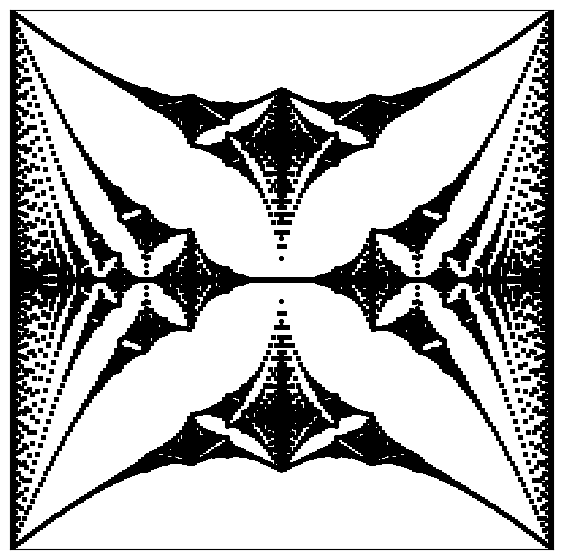

In [97]:
plt.figure(figsize=(7, 7))
for i in range(0, N+1):
    energies_at_alpha = energies[i]
    plt.scatter(i*np.ones(len(energies_at_alpha)), energies_at_alpha, s=5, color="black")
plt.xlim(0, N);
plt.ylim(-4, 4);
plt.xticks([])
plt.yticks([]);

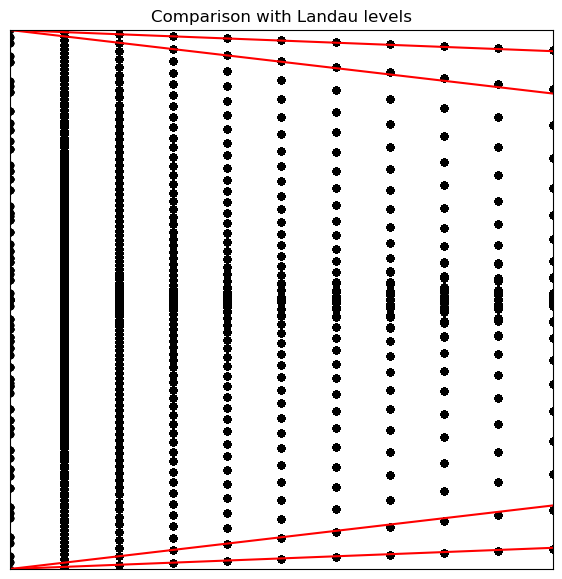

In [125]:
alphas = np.linspace(0, 1, N+1)
plt.figure(figsize=(7, 7))
for i in range(0, N+1):
    energies_at_alpha = energies[i]
    plt.scatter(i*np.ones(len(energies_at_alpha)), energies_at_alpha, s=20, color="black")
plt.plot(-4 + 4*pi*alphas*(1/2), color="red")
plt.plot(-4 + 4*pi*alphas*(3/2), color="red")
plt.plot(4 - 4*pi*alphas*(1/2), color="red")
plt.plot(4 - 4*pi*alphas*(3/2), color="red")

plt.xlim(0, 10);
plt.ylim(-4, 4);
plt.xticks([])
plt.yticks([]);
plt.title("Comparison with Landau levels");